# Przetwarzanie wstępne. Filtracja kontekstowa.


### Cel:
- zapoznanie z pojęciem kontekstu / filtracji kontekstowej,
- zapoznanie z pojęciem konwolucji (splotu),
- zapoznanie z wybranymi filtrami:
	- filtry liniowe dolnoprzepustowe:
		- filtr uśredniający,
		- filtr Gaussa.
	- filtry nielinowe:
		- mediana,
		- mediana dla obrazów kolorowych.
	- filtry liniowe górnoprzepustowe:
			- laplasjan,
			- operator Robersta, Prewitta, Sobela.
- zadanie domowe: adaptacyjna filtracja medianowa.

### Filtry liniowe uśredniające (dolnoprzepustowe)

Jest to podstawowa rodzina filtrów stosowana w cyfrowym przetwarzaniu obrazów. 
Wykorzystuje się je w celu "rozmazania" obrazu i tym samym redukcji szumów (zakłóceń) na obrazie.
Filtr określony jest przez dwa parametry: rozmiar maski (ang. _kernel_) oraz wartości współczynników maski.

Warto zwrócić uwagę, że omawiane w niniejszym rozdziale operacje generują nową wartość piksela na podstawie pewnego fragmentu obrazu (tj. kontekstu), a nie jak operacje punktowe tylko na podstawie jednego piksela.


1. Wczytaj obraz _plansza.png_.
W dalszej części ćwiczenia sprawdzenie działania filtracji dla innych obrazów sprowadzi się do wczytania innego pliku.

2. Podstawowa funkcja to `cv2.filter2D`  - realizacja filtracji konwolucyjnej.
   Proszę sprawdzić jej dokumentację i zwrócić uwagę na obsługę problemu brzegowego (na krawędziach istnieją piksele dla których nie da się wyznaczyć otoczenia).

  Uwaga. Problem ten można też rozwiązać z użyciem funkcji `signal.convolve2d` z biblioteki _scipy_ (`from scipy import signal`).

3. Stwórz podstawowy filtr uśredniający o rozmiarze $3 \times 3$ -- za pomocą funkcji `np.ones`. Wykonaj konwolucję na wczytanym obrazie. Na wspólnym rysunku wyświetl obraz oryginalny, po filtracji oraz moduł z różnicy.

4. Przeanalizuj otrzymane wyniki. Jakie elementy zawiera obraz "moduł z różnicy"? Co na tej podstawie można powiedzieć o filtracji dolnoprzepustowej?

In [75]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/06_Context/'

fileNames = ["jet.png", "kw.png", "moon.png", "lenaSzum.png", "lena.png", "plansza.png"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

5. Na wspólnym rysunku wyświetl wyniki filtracji uśredniającej z oknem o rozmiarze 3, 5, 9, 15 i 35. 
Wykorzystaj polecenie `plt.subplot`. 
Przeanalizuj wpływ rozmiaru maski na wynik. 

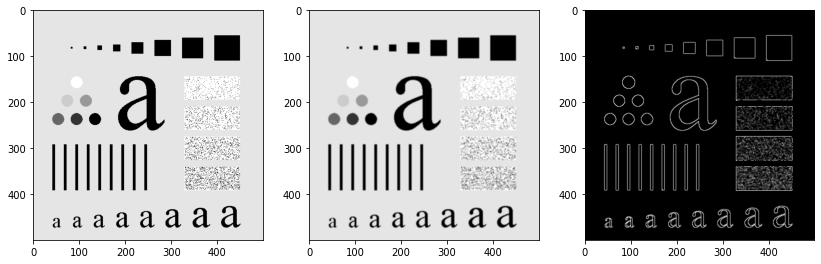

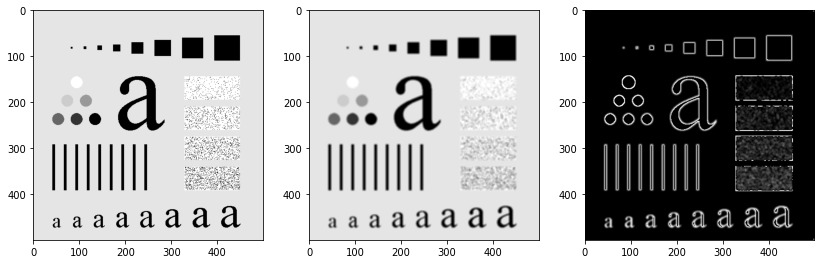

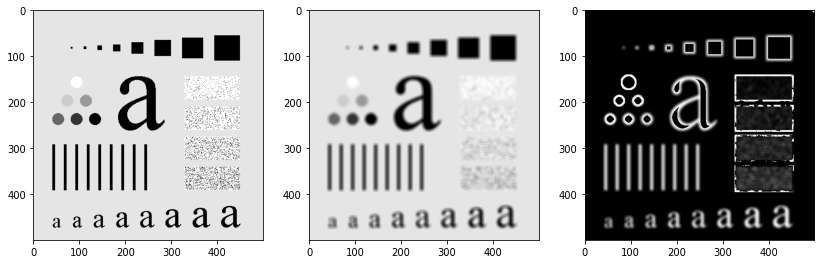

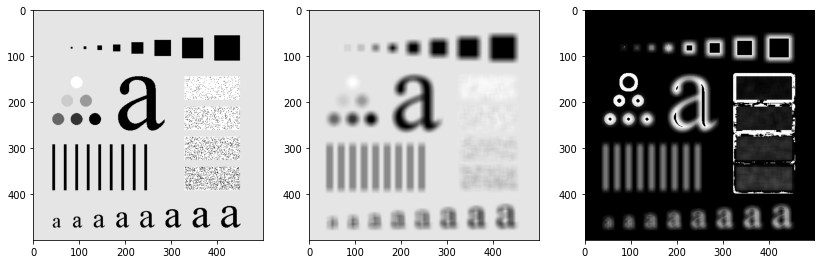

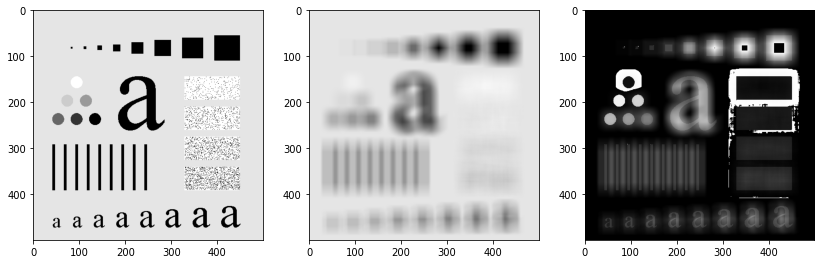

In [76]:
kernel_sizes = [(3, 3), (5, 5), (9, 9), (15, 15), (35, 35)]
plansza = cv2.imread("plansza.png")

def use_filter(img, size, filer_=0):

    if filer_ != 0:
        kernel = np.ones(size)
        kernel = kernel/size[0]**2
    else:
        kernel = np.ones(size)/size[0]**2

    result = cv2.filter2D(img, -1, kernel)

    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(14, 8)
    axs[0].imshow(img)
    axs[1].imshow(result)
    axs[2].imshow(abs(img - result))

for s in kernel_sizes:
    use_filter(plansza, s)

6. Wczytaj obraz _lena.png_.
Zaobserwuj efekty filtracji dolnoprzepustowej dla obrazu rzeczywistego.

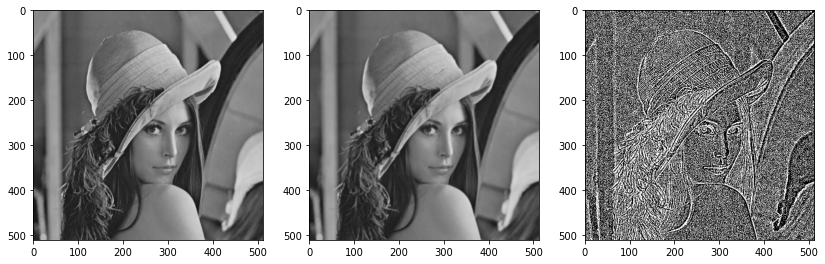

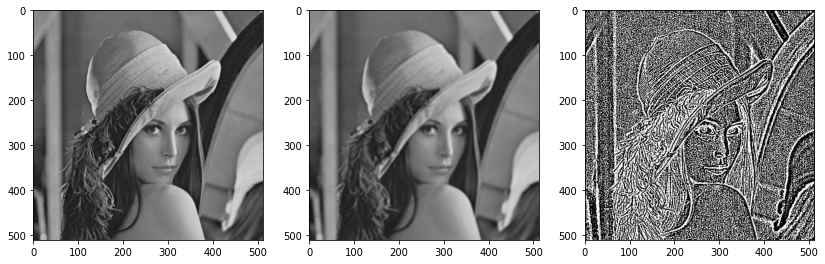

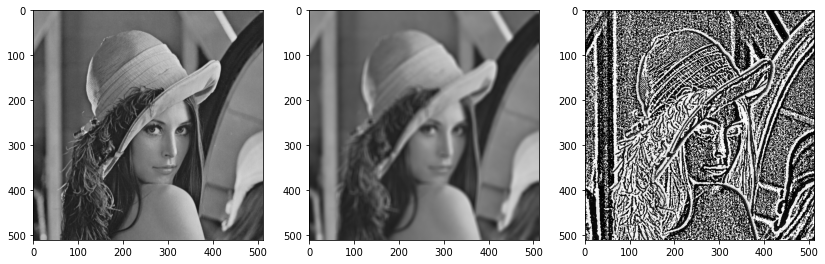

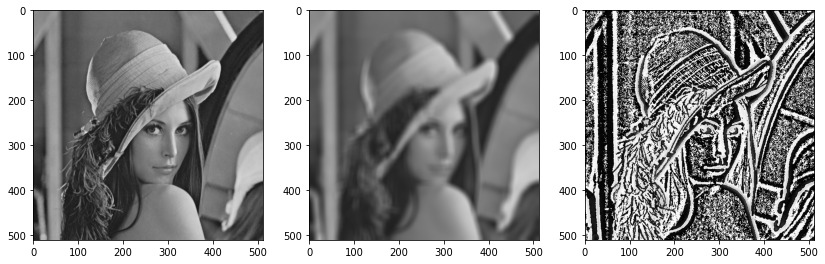

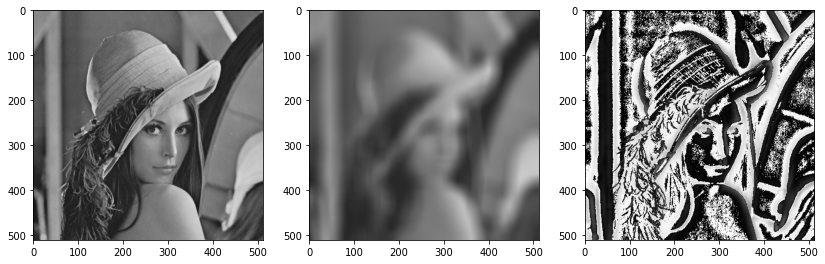

In [77]:
lena = cv2.imread('lena.png')
for s in kernel_sizes:
    use_filter(lena, s, 1)

7. Niekorzystny efekt towarzyszący wykonanym filtracjom dolnoprzepustowym to utrata ostrości. 
Częściowo można go zniwelować poprzez odpowiedni dobór maski. 
Wykorzystaj maskę:  `M = np.array([1 2 1; 2 4 2; 1 2 1])`. 
Przed obliczeniami należy jeszcze wykonać normalizację - podzielić każdy element maski przez sumę wszystkich elementów: `M = M/sum(sum(M));`.
Tak przygotowaną maskę wykorzystaj w konwolucji - wyświetl wyniki tak jak wcześniej.
Możliwe jest też wykorzystywanie innych masek - współczynniki można dopasowywać do konkretnego problemu.

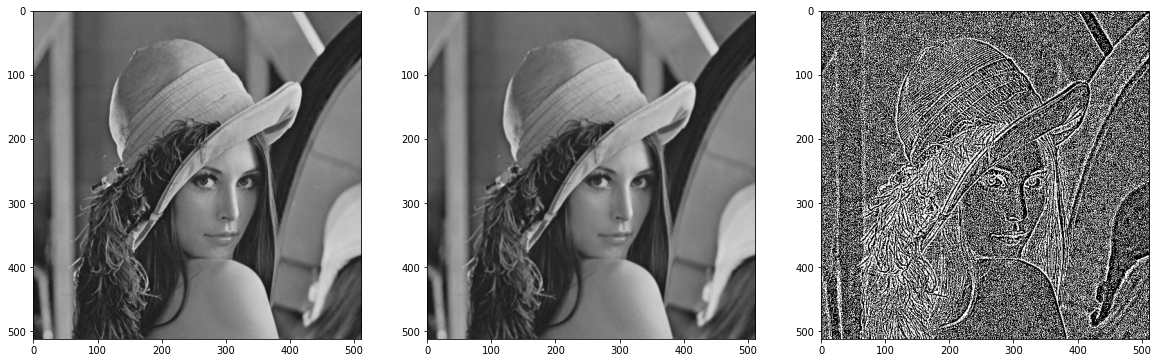

In [78]:
M = np.array([[1, 2, 1],
                    [2, 4, 2],
                    [1, 2, 1]])

M = M/sum(sum(M))

def filter_with_mask(img, mask):
    result = cv2.filter2D(img, -1, mask)
    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(20, 8)
    axs[0].imshow(img)
    axs[1].imshow(result)
    axs[2].imshow(abs(img - result))

filter_with_mask(lena, M)

8. Skuteczną i często wykorzystywaną maską jest tzw. maska Gasussa.
Jest to zbiór liczb, które aproksymują dwuwymiarowy rozkład Gaussa. 
Parametrem jest odchylenie standardowe i rozmiar maski.

9. Wykorzystując przygotowaną funkcję `fgaussian` stwórz maskę o rozmiarze $5 \times 5$ i odchyleniu standardowym 0.5.
  Wykorzystując funkcję `mesh` zwizualizuj filtr.
  Sprawdź jak parametr ``odchylenie standardowe'' wpływa na ``kształt'' filtru.

  Uwaga. W OpenCV dostępna jest *dedykowana* funkcja do filtracji Gaussa - `GaussianBlur`.
  Proszę na jednym przykładzie porównać jej działanie z użytym wyżej rozwiązaniem.

10. Wykonaj filtrację dla wybranych (2--3) wartości odchylenia standardowego.


In [79]:
def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g /g.sum() 
    
    
def mesh(fun, size):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun
    
    ax.plot_surface(X, Y, Z)
    plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_18728\825183722.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


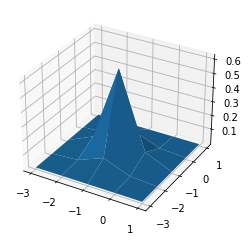

In [80]:
M = fgaussian(5, 0.5)
mesh(M, 5)

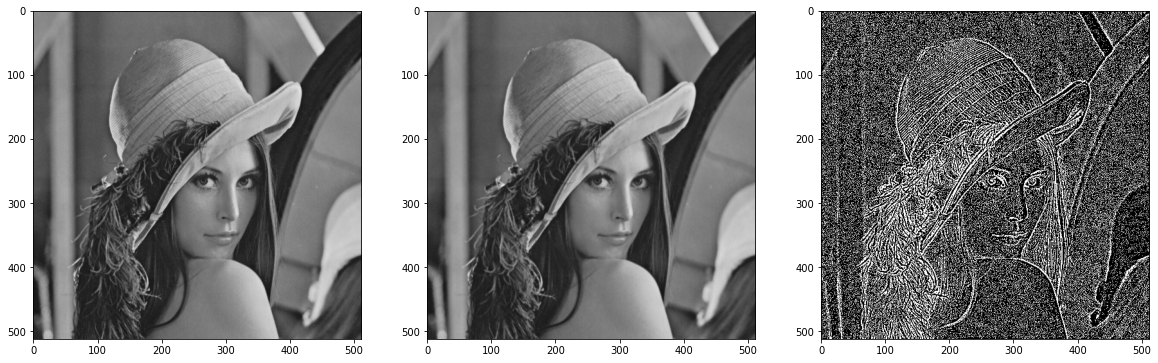

In [81]:
filter_with_mask(lena, M)

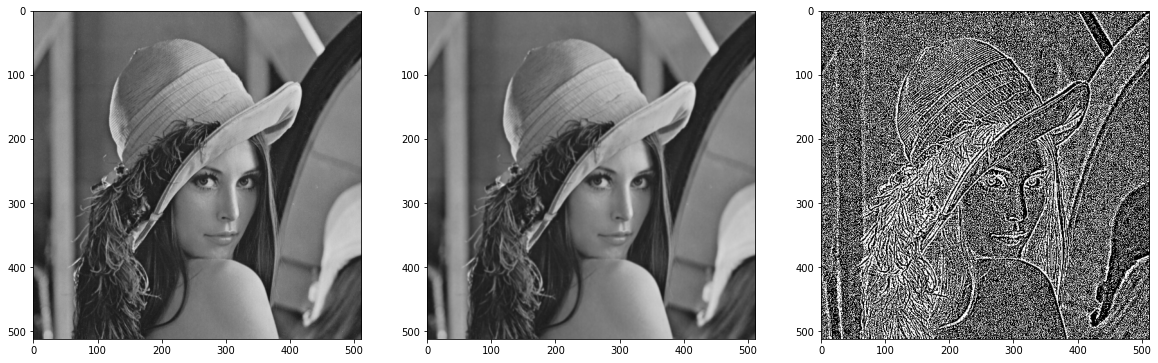

In [82]:
M = fgaussian(5, 0.7)
filter_with_mask(lena, M)

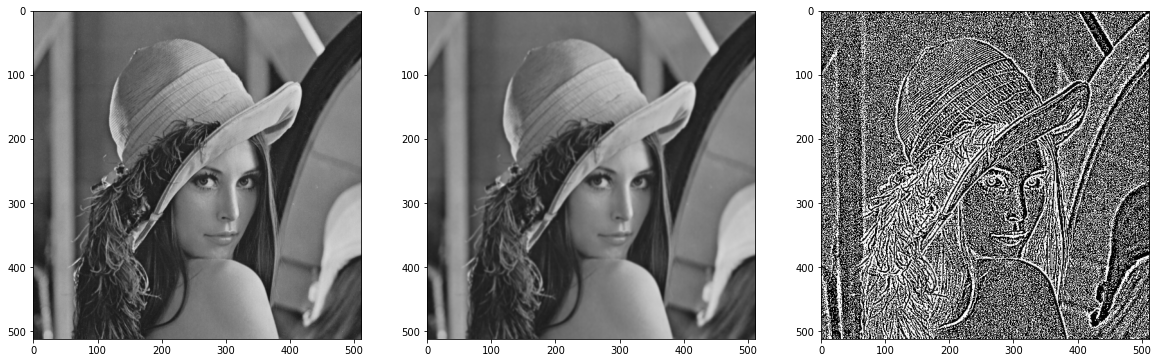

In [83]:
M = fgaussian(5, 1)
filter_with_mask(lena, M)

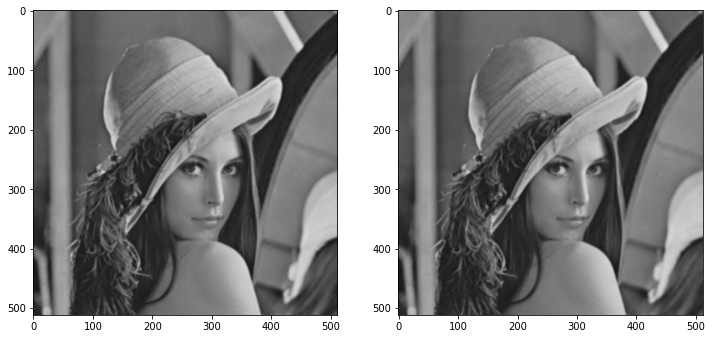

In [84]:
blur = cv2.GaussianBlur(lena,(5,5),0)
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 8)
axs[0].imshow(cv2.filter2D(lena, -1, M))
axs[1].imshow(blur)

### Filtry nieliniowe -- mediana

Filtry rozmywające redukują szum, ale niekorzystnie wpływają na ostrość obrazu.
Dlatego często wykorzystuje się filtry nieliniowe - np. filtr medianowy (dla przypomnienia: mediana - środkowa wartość w posortowanym ciągu liczb).

Podstawowa różnica pomiędzy filtrami liniowymi, a nieliniowymi polega na tym, że przy filtracji liniowej na nową wartość piksela ma wpływ wartość wszystkich pikseli z otoczenia (np. uśrednianie, czasem ważone), natomiast w przypadku filtracji nieliniowej jako nowy piksel wybierana jest któraś z wartości otoczenia - według jakiegoś wskaźnika (wartość największa, najmniejsza czy właśnie mediana).


1. Wczytaj obraz _lenaSzum.png_ (losowe 10% pikseli białych lub czarnych - tzw. zakłócenia impulsowe). Przeprowadź filtrację uśredniającą z rozmiarem maski 3x3. Wyświetl, podobnie jak wcześniej, oryginał, wynik filtracji i moduł z różnicy. Wykorzystując funkcję ``cv2.medianBlur` wykonaj filtrację medianową _lenaSzum.png_ (z rozmiarem maski $3 \times 3$). Wyświetl, podobnie jak wcześniej, oryginał, wynik filtracji i moduł z różnicy. Która filtracja lepiej radzi sobie z tego typu szumem?

  Uwaga. Taki sam efekt da również użycie funkcji `signal.medfilt2d`.


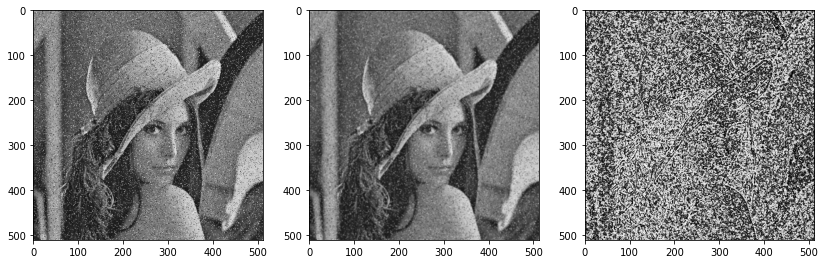

In [85]:
lena_szum = cv2.imread('lenaSzum.png')
use_filter(lena_szum, (3,3), 1)

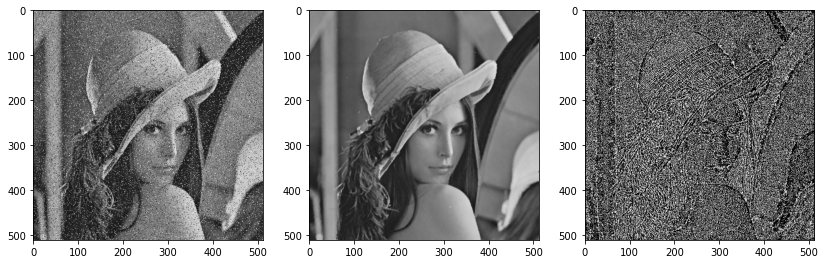

In [86]:
res = cv2.medianBlur(lena_szum,3)
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(14, 8)
axs[0].imshow(lena_szum)
axs[1].imshow(res)
axs[2].imshow(abs(lena_szum - res))

2. Przeprowadź filtrację uśredniającą, a następnie medianową obrazu _lena.png_.
   Wyniki porównaj - dla obu wyświetl: oryginał, wynik filtracji i moduł z różnicy.
   Szczególną uwagę zwróć na ostrość i krawędzie.
   W której filtracji krawędzie zostają lepiej zachowane?

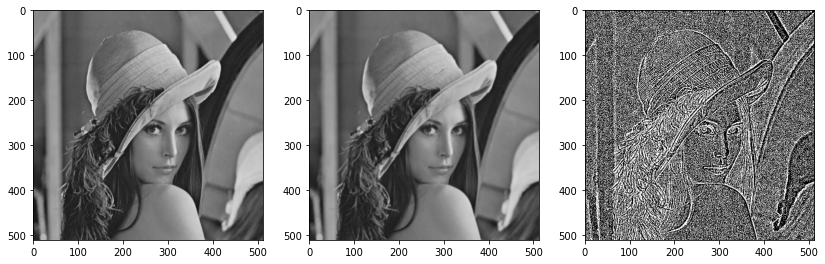

In [87]:
use_filter(lena, (3,3), 1)

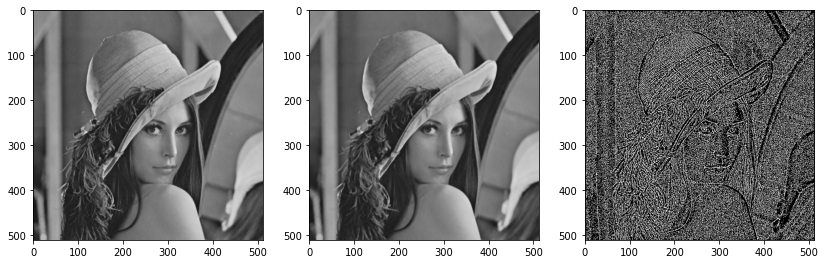

In [88]:
res = cv2.medianBlur(lena,3)
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(14, 8)
axs[0].imshow(lena)
axs[1].imshow(res)
axs[2].imshow(abs(lena - res))

3. Ciekawy efekt można uzyskać wykonując filtrację medianową wielokrotnie. Określa się go mianem  posteryzacji.  W wyniku przetwarzania z obrazka usunięte zostają detale, a duże obszary uzyskują tą samą wartość jasności.  Wykonaj operację mediany $5 \times 5$ na obrazie _lena.png_ 10-krotnie. (wykorzystaj np. pętlę `for`).


Inne filtry nieliniowe:
- filtr modowy - moda (dominanta) zamiast mediany,
- filtr olimpijski - średnia z podzbioru otoczenia (bez wartości ekstremalnych),
- hybrydowy filtr medianowy - mediana obliczana osobno w różnych podzbiorach otoczenia (np. kształt ``x'',``+''), a jako wynik brana jest mediana ze zbioru wartość elementu centralnego, mediana z ``x'' i mediana z ``+'',
- filtr minimalny i maksymalny (będą omówione przy okazji operacji morfologicznych w dalszej części kursu).


Warto zdawać sobie sprawę, z szerokich możliwości dopasowywania rodzaju filtracji do konkretnego rozważanego problemu i rodzaju zaszumienia występującego na obrazie.

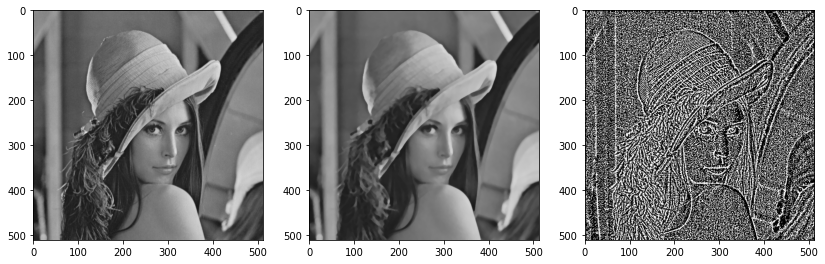

In [89]:
kernel = np.ones((5,5))
kernel = kernel/5**2
# result = cv2.filter2D(lena, -1, kernel)
result = cv2.medianBlur(lena, 5)

for i in range(9):
    # result = cv2.filter2D(result, -1, kernel)
    result = cv2.medianBlur(result,3)

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(14, 8)
axs[0].imshow(lena)
axs[1].imshow(result)
axs[2].imshow(abs(lena - result))

## Filtry liniowe górnoprzepustowe (wyostrzające, wykrywające krawędzie)

Zadaniem filtrów górnoprzepustowych jest wydobywanie z obrazu składników odpowiedzialnych za szybkie zmiany jasności - konturów, krawędzi, drobnych elementów tekstury.

### Laplasjan (wykorzystanie drugiej pochodnej obrazu)

1. Wczytaj obraz _moon.png_.

2. Wprowadź podstawową maskę laplasjanu:
\begin{equation}
M = 
\begin{bmatrix}
0 & 1& 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0
\end{bmatrix}
\end{equation}

3. Przed rozpoczęciem obliczeń należy dokonać normalizacji maski - dla rozmiaru $3 \times 3$ podzielić każdy element przez 9.
   Proszę zwrócić uwagę, że nie można tu zastosować takiej samej normalizacji, jak dla filtrów dolnoprzepustowanych, gdyż skutkowałby to dzieleniem przez 0.

4. Wykonaj konwolucję obrazu z maską (`c2.filter2D`). Przed wyświetleniem, wynikowy obraz należy poddać normalizacji (występują ujemne wartości). Najczęściej wykonuje się jedną z dwóch operacji:
- skalowanie (np. poprzez dodatnie 128 do każdego z pikseli),
- moduł (wartość bezwzględna).

Wykonaj obie normalizacje. 
Na wspólnym wykresie wyświetl obraz oryginalny oraz przefiltrowany po obu normalizacjach. 

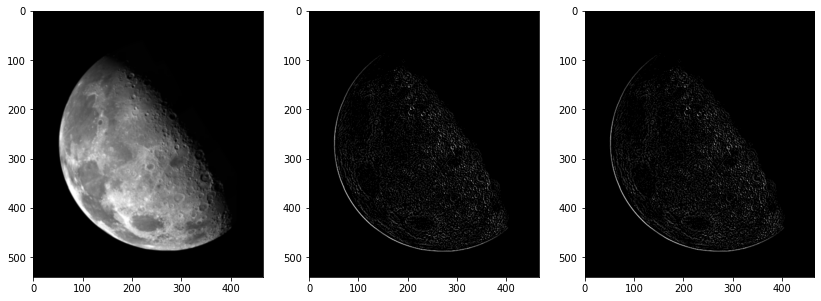

In [90]:
moon = cv2.imread('moon.png',0)
M = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
M = M / 9

result_1 = (cv2.filter2D(moon, -1, M) + 128)
result_2 = abs(cv2.filter2D(moon, -1, M))
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(14, 8)
axs[0].imshow(moon, cmap="gray")
axs[1].imshow(result_1, cmap="gray")
axs[2].imshow(result_2, cmap="gray")

7. Efekt wyostrzenia uzyskuje się po odjęciu/dodaniu (zależy do maski) rezultatu filtracji laplasjanowej i oryginalnego obrazu. Wyświetl na jednym wykresie: obraz oryginalny, sumę oryginału i wyniku filtracji oraz różnicę (bezwzględną) oryginału i wyniku filtracji.
 Uwaga. Aby uniknąć artefaktów, należy obraz wejściowy przekonwertować do formatu ze znakiem.



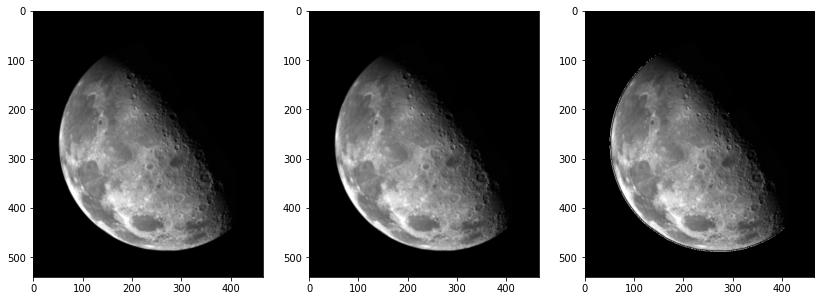

In [91]:
sum_1 = moon + result_1
sub_1 = abs(moon - result_1)

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(14, 8)
axs[0].imshow(moon, cmap="gray")
axs[1].imshow(sum_1.astype("int8"), cmap="gray")
axs[2].imshow(sub_1.astype("int8"), cmap="gray")

### Gradienty (wykorzystanie pierwszej pochodnej obrazu)

1. Wczytaj obraz _kw.png_. Stwórz odpowiednie maski opisane w kolejnych punktach i dokonaj filtracji.
2. Wykorzystując gradient Robertsa przeprowadź detekcję krawędzi - poprzez wykonanie konwolucji obrazu z daną maską:
\begin{equation}
R1 = \begin{bmatrix} 0 & 0 & 0 \\ -1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}
R2 = \begin{bmatrix} 0 & 0 & 0 \\ 0 & 0 & -1 \\ 0 & 1 & 0 \end{bmatrix}
\end{equation}

Wykorzystaj stworzony wcześniej kod (przy laplasjanie) - dwie metody normalizacji oraz sposób wyświetlania.

3. Analogicznie przeprowadź detekcję krawędzi za pomocą gradientu Prewitta (pionowy i poziomy)
\begin{equation}
P1 = \begin{bmatrix} -1 & 0 & 1 \\ -1 & 0 & 1 \\ -1 & 0 & 1 \end{bmatrix}
P2 = \begin{bmatrix} -1 & -1 & -1 \\ 0 & 0 & 0 \\ 1 & 1 & 1 \end{bmatrix}
\end{equation}

4. Podobnie skonstruowany jest gradient Sobela (występuje osiem masek, zaprezentowane są dwie ``prostopadłe''):
\begin{equation}
S1 = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}
S2 = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix}
\end{equation}

Przeprowadź detekcję krawędzi za pomocą gradientu Sobela.

In [92]:
def gradient(img, mask):
    mask = mask / 9
    result_ = (cv2.filter2D(img, -1, mask) + 128)
    result__ = abs(cv2.filter2D(img, -1, mask))

    sum_ = img + result__
    sub_ = abs(img - result__)

    fig_, axs_ = plt.subplots(1, 5)
    fig_.set_size_inches(24, 20)
    axs_[0].set_title('original')
    axs_[0].imshow(img, cmap="gray")
    axs_[1].set_title('normalised +128')
    axs_[1].imshow(result_, cmap="gray")
    axs_[2].set_title('normalised abs')
    axs_[2].imshow(result__, cmap="gray")
    axs_[3].set_title('sum')
    axs_[3].imshow(sum_, cmap="gray")
    axs_[4].set_title('sub')
    axs_[4].imshow(sub_, cmap="gray")

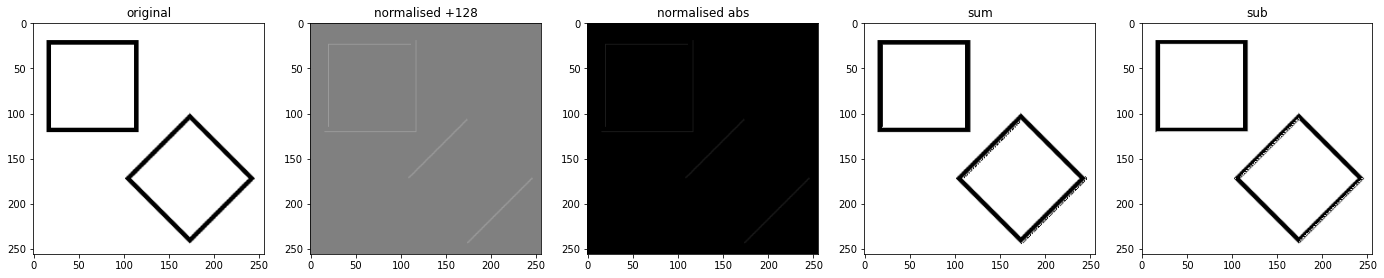

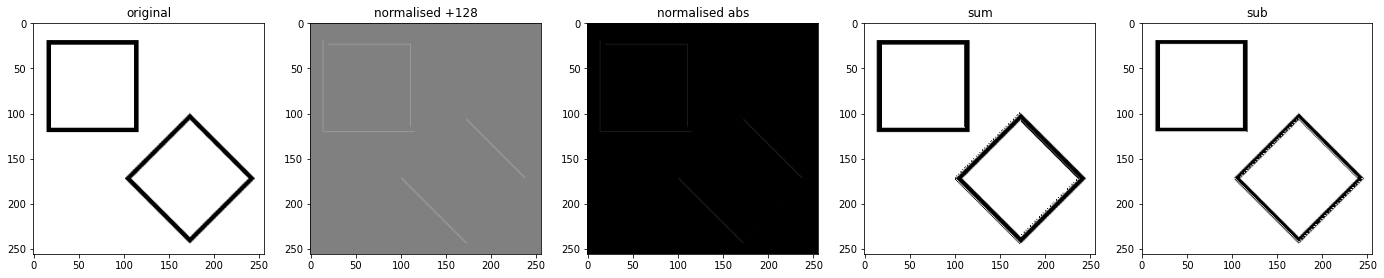

In [93]:
kw = cv2.imread('kw.png')

R1 = np.array([[0, 0, 0], [-1, 0, 0], [0, 1, 0]])
R2 = np.array([[0, 0, 0], [0, 0, -1 ], [0, 1, 0 ]])

gradient(kw, R1)
gradient(kw, R2)

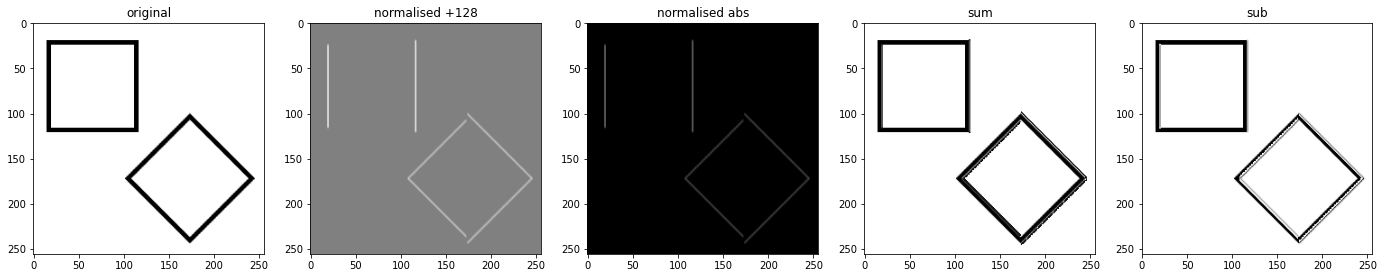

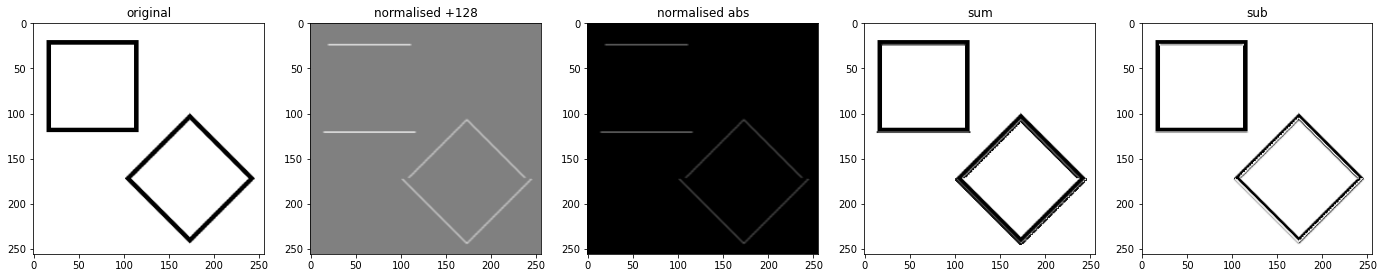

In [94]:
P1 = np.array([[-1, 0, 1 ], [-1, 0, 1], [-1, 0, 1]])
P2 = np.array([[-1, -1, -1 ], [0, 0, 0], [1, 1, 1]])

gradient(kw, P1)
gradient(kw, P2)

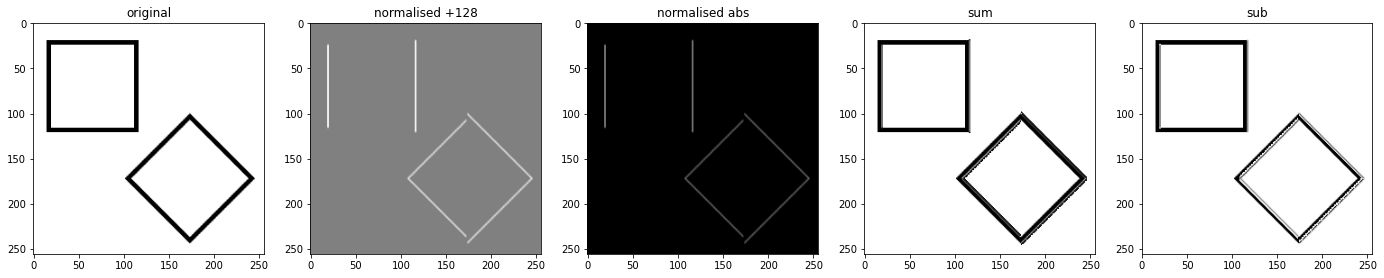

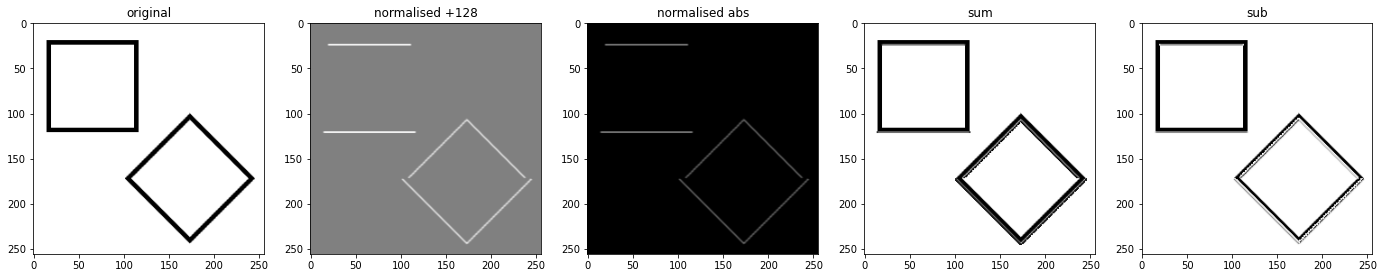

In [95]:
S1 = np.array([[-1, 0, 1], [-2, 0, 2 ], [-1, 0, 1]])
S2 = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

gradient(kw, S1)
gradient(kw, S2)

5. Na podstawie dwóch ortogonalnych masek np. Sobela można stworzyć tzw. filtr kombinowany - pierwiastek kwadratowy z sumy kwadratów gradientów:
\begin{equation}
OW = \sqrt{(O * S1)^2 + (O * S2)^2}
\end{equation}
gdzie:  $OW$ - obraz wyjściowy, $O$ - obraz oryginalny (wejściowy), $S1,S2$ - maski Sobela, $*$ - operacja konwolucji.

Zaimplementuj filtr kombinowany.

Uwaga. Proszę zwrócić uwagę na konieczność zmiany formatu danych obrazu wejściowego - na typ znakiem



In [96]:
def combined(img, m1, m2):
    # img = img.astype("int8")
    m1 = m1 / 9
    m2 = m2 / 9
    mul_ = cv2.filter2D(img, -1, m1)
    mul__ = cv2.filter2D(img, -1, m2)
    mul_ = mul_**2
    mul__ = mul__**2
    res_img = np.square(mul_ + mul__)
    return res_img

6. Istnieje alternatywna wersja filtra kombinowanego, która zamiast pierwiastka z sumy kwadratów wykorzystuje sumę modułów (prostsze obliczenia). 
Zaimplementuj tę wersję. 

In [97]:
def combined_sum(img, m1, m2):
    # img = img.astype("int8")
    m1 = m1 / 9
    m2 = m2 / 9
    mul_ = cv2.filter2D(img, -1, m1)
    mul__ = cv2.filter2D(img, -1, m2)
    mul_ = np.absolute(mul_)
    mul__ = np.absolute(mul__)
    res_img = mul_ + mul__
    return res_img

7. Wczytaj plik _jet.png_ (zamiast _kw.png_).
Sprawdź działanie obu wariantów filtracji kombinowanej.

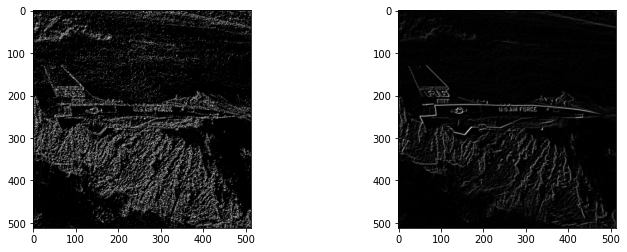

In [98]:
jet = cv2.imread('jet.png', 0)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
axs[0].imshow(combined(jet, S1, S2), cmap="gray")
axs[1].imshow(combined_sum(jet, S1, S2), cmap="gray")